In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize as pymoo_minimize

from arima_utils import(
    create_periodic_arima_objective,
    Tier2MOGAProblem,
    FromTier1SeedSampling,
    BASE_COST,
    SLIPPAGE,
    DEFAULT_T2_NGEN_ARIMA
)

In [2]:
data_dir = 'data/scaled_folds'
tier1_json = 'data/tuning_results/jsons/tier1_arima.json'
tier2_json = 'data/tuning_results/jsons/tier2_arima_debug.json'
tier2_csv = 'data/tuning_results/csv/tier2_arima_debug.csv'
retrain_intervals = [10, 20, 42]
max_folds = 1 

os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

np.random.seed(42)

In [3]:
with open(os.path.join(data_dir, 'folds_summary_rescaled.json')) as f:
    summary = {f['fold_id']: f for f in json.load(f)['arima']}

with open(os.path.join(data_dir, 'arima', 'arima_tuning_folds.json')) as f:
    reps = [r['fold_id'] for r in json.load(f)]

with open(tier1_json) as f:
    champions_raw = json.load(f)
    champions = {r['fold_id']: r['best_params'] for r in champions_raw if r['fold_id'] in reps}

if max_folds:
    champions = dict(list(champions.items())[:max_folds])

In [4]:
fid, params = list(champions.items())[0]
info = summary[fid]
print(f"Debugging Fold: {fid}, Best Params from Tier 1: {params}")

Debugging Fold: 18, Best Params from Tier 1: {'p': 5, 'd': 0, 'q': 4}


In [5]:
train = pd.read_csv(os.path.join(data_dir, info['train_path']))
val = pd.read_csv(os.path.join(data_dir, info['val_path']))
train_ret = train['Log_Returns'].dropna().values.astype(np.float64)
val_ret = val['Log_Returns'].dropna().values.astype(np.float64)

In [6]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling

def sharpe_ratio(r):
    std = np.std(r)
    return 0.0 if std == 0 else (np.mean(r) / std) * np.sqrt(252)

def max_drawdown(r):
    if len(r) == 0:
        return 0.0
    cum = np.exp(np.cumsum(r))
    peak = np.maximum.accumulate(cum)
    return np.max((peak - cum) / (peak + np.finfo(float).eps))

In [7]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.5 < rel_thresh < 2.5):
            return 1e3, 1e3

        history = train.copy()
        all_simple_returns = []
        all_log_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)
            z_score = (forecast - forecast.mean()) / (forecast.std() + 1e-8)

            signals = (z_score > rel_thresh).astype(int)
            if signals.sum() < 3:
                return 1e3, 1e3
            
            val_block_log = val[start:end]
            val_block_simple = np.exp(val_block_log) - 1

            block_simple_return = val_block_simple * signals - cost * signals
            all_simple_returns.append(block_simple_return)

            block_log_return = np.log(1 + block_simple_return + 1e-8)  
            all_log_returns.append(block_log_return)

            history = np.concatenate([history, val[start:end]])

        net_simple_returns = np.concatenate(all_simple_returns)
        net_log_returns = np.concatenate(all_log_returns)

        return -sharpe_ratio(net_simple_returns), max_drawdown(net_log_returns)

    return objective

In [8]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.5]
print("Test objective value:", obj(test_params))

Test objective value: (1000.0, 1000.0)


In [40]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            threshold_value = np.quantile(forecast, rel_thresh)
            signals = (forecast > threshold_value).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [41]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: [1 1 1 1 1 1 0 1 1 1], sum=19 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
  net_ret  = [-0.06994641 -0.35136589  0.94738     0.24121856  0.15606147 -0.18096869
 -0.         -0.01453626  0.31361055  0.52477343 -0.31448724  0.14839891
  0.63591579  0.86603564 -0.05893617 -0.28701113  1.01743363 -0.57130246
  1.41718473 -0.33455991], total=4.0848985411576715
Signals: [0 1 1 1 1 1 1 1 1 1], sum=19 | rel_thresh=0.050
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
  si

In [42]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            series = pd.Series(forecast)
            rolling = series.rolling(window=5, min_periods=1).mean()
            deviation = series - rolling
            signals = (deviation > 0.05).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [43]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: 0    0
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    1
9    1
dtype: int64, sum=8 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = 0     0
1     0
2     0
3     1
4     1
5     0
6     0
7     0
8     1
9     1
10    0
11    0
12    1
13    1
14    0
15    0
16    0
17    1
18    1
19    0
dtype: int64
  net_ret  = 0    -0.000000
1    -0.000000
2     0.000000
3     0.241219
4     0.156061
5    -0.000000
6    -0.000000
7    -0.000000
8     0.313611
9     0.524773
10   -0.000000
11    0.000000
12    0.635916
13    0.866036
14   -0.000000
15   -0.000000
16    0.000000
17   -0.571302
18    1.417185
19   -0.000000
dtype: float64, total=3.583497700089791
Signals: 0    0
1    1
2    1
3    0
4    0
5    0
6    1
7    1
8    0
9

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            expected_ret = forecast - cost
            signals = (expected_ret > 0).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [45]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: [1 0 0 1 1 0 0 1 1 1], sum=11 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = [1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0]
  net_ret  = [-0.06994641 -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.01453626  0.31361055  0.52477343 -0.          0.
  0.63591579  0.86603564 -0.         -0.          1.01743363 -0.57130246
  1.41718473 -0.        ], total=4.51644867132669
Signals: [0 1 1 1 0 0 1 1 0 0], sum=11 | rel_thresh=0.050
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
  signals  = [0 1 1 1 

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [56]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            forecast = model.forecast(steps=10)
            forecast_sum = np.sum(forecast)

            if forecast_sum > cost * 5:
                signals = 1

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [57]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344]
  signals  = 1
  net_ret  = [-0.06994641 -0.35136589  0.94738     0.24121856  0.15606147 -0.18096869
 -0.03253941 -0.01453626  0.31361055  0.52477343 -0.31448724  0.14839891
  0.63591579  0.86603564 -0.05893617 -0.28701113  1.01743363 -0.57130246
  1.41718473 -0.33455991], total=4.052359130201466
Block 20-40:
  forecast = [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069]
  signals  = 1
  net_ret  = [ 0.06470574 -0.91200453 -0.57008255  0.51723452  0.33140938  0.00417292
  0.3166616  -1.23806788 -0.57062196 -0.13848123  1.48080276  0.98036469
  0.4474386   0.04954408  0.156328   -0.57328906  0.36470567 -1.41884716
 -0.92024485 -1.08452277], total=-2.7127940191632804
Block 40-42:
  forecast = [ 0.12715913  0.28284722  0.16283083  0.04423025  0.15193391  0.26088042
  0.08

In [54]:
def create_periodic_arima_objective(train, val, retrain_interval, cost):
    def objective(x):
        p, q, rel_thresh = int(x[0]), int(x[1]), float(x[2])
        if not (0.0 < rel_thresh < 1.0):
            return 1e3, 1e3
        
        history = train.copy()
        all_returns = []
        n = len(val)

        for start in range(0, n, retrain_interval):
            end = min(start + retrain_interval, n)
            try:
                model = ARIMA(history, order=(p, 0, q)).fit()
            except Exception:
                return 1e3, 1e3

            h = end - start
            forecast = model.forecast(steps=h)

            forecast_series = pd.Series(forecast)
            z = (forecast_series - forecast_series.mean()) / (forecast_series.std() + 1e-8)
            rolling = forecast_series.rolling(window=5, min_periods=1).mean()
            deviation = forecast_series - rolling
            signals = ((z > 1.0) & (deviation > 0.003)).astype(int)
            if signals.sum() == 0:
                return 1e3, 1e3
            print(f"Signals: {signals[:10]}, sum={signals.sum()} | rel_thresh={rel_thresh:.3f}")

            block_returns = val[start:end] * signals - cost * signals
            print(f"Block {start}-{end}:")
            print(f"  forecast = {forecast}")
            print(f"  signals  = {signals}")
            print(f"  net_ret  = {block_returns}, total={block_returns.sum()}")
            all_returns.append(block_returns)
            history = np.concatenate([history, val[start:end]])

        net_returns = np.concatenate(all_returns)
        print(f"Net returns sum: {net_returns.sum():.6f}, Sharpe: {sharpe_ratio(net_returns):.4f}")
        return -sharpe_ratio(net_returns), max_drawdown(net_returns)

    return objective


In [55]:
obj = create_periodic_arima_objective(train_ret, val_ret, retrain_interval=20, cost=BASE_COST + SLIPPAGE)
test_params = [params['p'], params['q'], 0.05]
print("Test objective value:", obj(test_params))

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Signals: 0    0
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    1
9    0
dtype: int64, sum=5 | rel_thresh=0.050
Block 0-20:
  forecast = [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
  signals  = 0     0
1     0
2     0
3     1
4     1
5     0
6     0
7     0
8     1
9     0
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    1
18    0
19    0
dtype: int64
  net_ret  = 0    -0.000000
1    -0.000000
2     0.000000
3     0.241219
4     0.156061
5    -0.000000
6    -0.000000
7    -0.000000
8     0.313611
9     0.000000
10   -0.000000
11    0.000000
12    0.000000
13    0.866036
14   -0.000000
15   -0.000000
16    0.000000
17   -0.571302
18    0.000000
19   -0.000000
dtype: float64, total=1.0056237551631586
Signals: 0    0
1    0
2    1
3    0
4    0
5    0
6    1
7    1
8    0


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
def generate_signal(
    forecast: np.ndarray,
    strategy: str = "zscore",
    cost: float = 0.0007,
    z_thresh: float = 1.0,
    deviation_thresh: float = 0.002,
    window: int = 5,
    multi_step_sum_thresh: float = None
) -> np.ndarray:

    forecast = np.ravel(forecast)

    if strategy == "zscore":
        series = pd.Series(forecast)
        z = (series - series.mean()) / (series.std() + 1e-8)
        return (z > z_thresh).astype(int).values

    elif strategy == "rolling_dev":
        series = pd.Series(forecast)
        rolling = series.rolling(window=window, min_periods=1).mean()
        deviation = series - rolling
        return (deviation > deviation_thresh).astype(int).values

    elif strategy == "net_return":
        net_ret = forecast - cost
        return (net_ret > 0).astype(int)

    elif strategy == "multi_step":
        total_ret = np.sum(forecast)
        if multi_step_sum_thresh is None:
            multi_step_sum_thresh = cost * len(forecast)
        signal = int(total_ret > multi_step_sum_thresh)
        return np.full_like(forecast, signal, dtype=int)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def debug_arima_block(train, val, p, q,
                      retrain_interval=20,
                      cost=0.0007,
                      strategy='zscore',
                      strategy_kwargs=None):
    if strategy_kwargs is None:
        strategy_kwargs = {}
        
    history = train.copy()
    n = len(val)
    cum_returns = []
    cumulative = 0

    for start in range(0, n, retrain_interval):
        h = min(retrain_interval, n - start)
        end = start + h

        try:
            # CLEAN history to avoid dtype=object errors
            history = np.asarray(history, dtype=np.float64)
            model = ARIMA(history, order=(p, 0, q)).fit()
            forecast = model.forecast(steps=h)
        except Exception as e:
            print(f"[ERROR] Block {start}-{end}: {e}")
            forecast = np.zeros(h)

        model = ARIMA(history, order=(p, 0, q)).fit()
        forecast = model.forecast(steps=h)

        # ---------- Signal Strategy ----------
        signals = generate_signal(
                    forecast=forecast,
                    strategy=strategy,
                    cost=cost,
                    **strategy_kwargs)

        # ---------- Return ----------
        actual_returns = np.array(val[start:end]).flatten()
        signals = np.array(signals).flatten()
        net_ret = actual_returns * signals - cost * signals
        cumulative += np.sum(net_ret)
        cum_returns.append(cumulative)

        print(f"\nBlock {start}-{end}")
        print(f"Forecast      : {forecast}")
        print(f"Strategy      : {strategy} | Params: {strategy_kwargs}")
        print(f"Signals       : {signals}, sum={signals.sum()}")
        print(f"Net returns   : {net_ret}")
        print(f"Cumulative    : {cumulative:.4f}")

        history = np.concatenate([history, actual_returns])

    # ---------- Plot ----------
    plt.plot(cum_returns, label=f"{strategy} | {strategy_kwargs}")
    plt.xlabel("Block Index")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

In [36]:
p, q = 3, 1
retrain_interval = 20
cost = 0.0007

strategies_to_test = [
    ("zscore", {"z_thresh": 0.8}),
    ("zscore", {"z_thresh": 1.0}),
    ("rolling_dev", {"deviation_thresh": 0.0015, "window": 5}),
    ("net_return", {}),
    ("multi_step", {"multi_step_sum_thresh": 0.005}),
]

plt.figure(figsize=(12, 6))
for strategy_name, kwargs in strategies_to_test:
    debug_arima_block(
        train=train,
        val=val,
        p=p, q=q,
        retrain_interval=retrain_interval,
        cost=cost,
        strategy=strategy_name,
        strategy_kwargs=kwargs
    )
plt.title(f"ARIMA({p},0,{q}) | Retrain={retrain_interval}")
plt.show()

[ERROR] Block 0-20: could not convert string to float: '2011-08-02'


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

<Figure size 1200x600 with 0 Axes>

In [ ]:
def hybrid_strategy(forecast):
    return generate_hybrid_signal(
        forecast,
        z_thresh=1.0,
        deviation_thresh=0.002,
        window=5,
        mode="and"
    )

debug_arima_block(
    train_data,
    val_data,
    p=4,
    q=1,
    retrain_interval=20,
    cost=0.0007,
    generate_signal_function=hybrid_strategy
)

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : quantile
Threshold     : 0.104760
Signals       : [0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0], sum=8
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.52477343 -0.          0.
  0.63591579  0.86603564 -0.         -0.          0.         -0.57130246
  1.41718473 -0.        ]
Cumulative    : 3.5835

Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : quantile
Threshold     : 0.026624
Signals       : [0 1

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


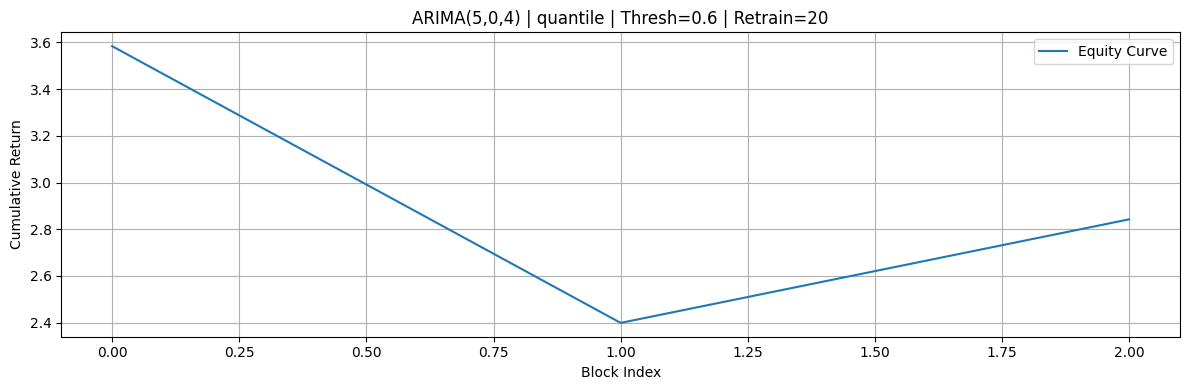

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : topk
Threshold     : 0.229152
Signals       : [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sum=3.0
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.         -0.          0.
  0.          0.         -0.         -0.          0.         -0.
  0.         -0.        ]
Cumulative    : 0.7109


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : topk
Threshold     : 0.112820
Signals       : [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], sum=3.0
Net returns   : [ 0.         -0.         -0.57008255  0.          0.          0.
  0.3166616  -0.         -0.         -0.          0.          0.98036469
  0.          0.          0.         -0.          0.         -0.
 -0.         -0.        ]
Cumulative    : 1.4378

Block 40-42
Forecast      : [0.12715913 0.28284722]
Strategy      : topk
Threshold     : 0.127159
Signals       : [1. 1.], sum=2.0
Net returns   : [-0.16779505  0.44316201]
Cumulative    : 1.7132


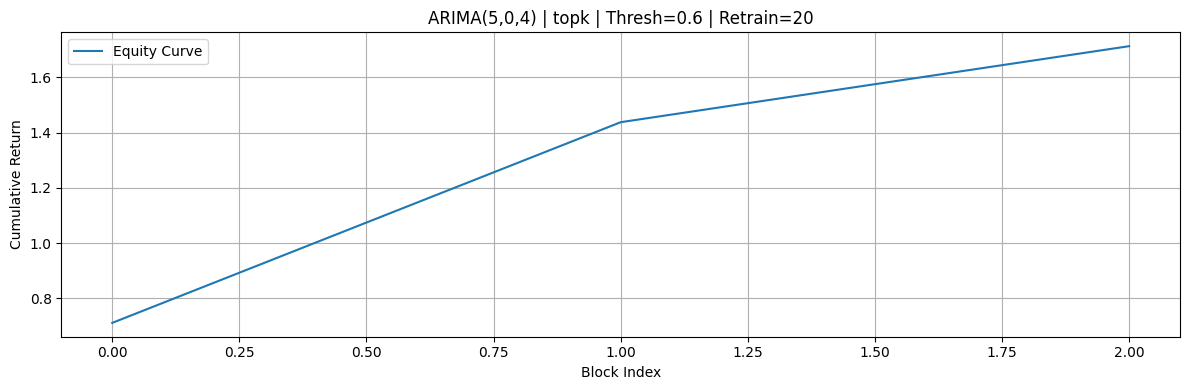

/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 0-20
Forecast      : [ 0.09701096 -0.18228395 -0.10133514  0.25992904  0.22915213 -0.05444235
 -0.19208186  0.07153582  0.26308351  0.11638344 -0.14730979 -0.08818841
  0.16706241  0.22103938 -0.01244517 -0.14393005  0.01975829  0.21217081
  0.12451191 -0.08800121]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0], sum=6
Net returns   : [-0.         -0.          0.          0.24121856  0.15606147 -0.
 -0.         -0.          0.31361055  0.         -0.          0.
  0.63591579  0.86603564 -0.         -0.          0.         -0.57130246
  0.         -0.        ]
Cumulative    : 1.6415


/Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Block 20-40
Forecast      : [-0.21544761  0.04215689  0.14713993  0.0046088  -0.16489425 -0.07831062
  0.11281964  0.1099223  -0.06951824 -0.13077069  0.01770151  0.13409008
  0.04000737 -0.10333514 -0.06700841  0.08344078  0.10729775 -0.02440772
 -0.09554314  0.00280588]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0], sum=6
Net returns   : [ 0.         -0.         -0.57008255  0.          0.          0.
  0.3166616  -1.23806788 -0.         -0.          0.          0.98036469
  0.          0.          0.         -0.57328906  0.36470567 -0.
 -0.         -0.        ]
Cumulative    : 0.9218

Block 40-42
Forecast      : [0.12715913 0.28284722]
Strategy      : zscore
Threshold     : 0.600000
Signals       : [0 1], sum=1
Net returns   : [-0.          0.44316201]
Cumulative    : 1.3650


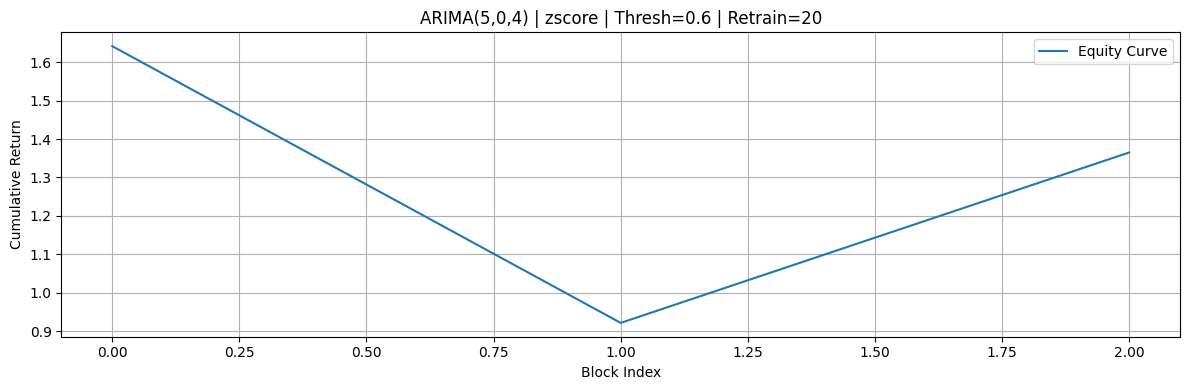

[np.float64(1.6415395428848547),
 np.float64(0.9218319995830341),
 np.float64(1.364994010011834)]

In [ ]:
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='quantile')
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='topk')
debug_arima_block(train_ret, val_ret, p=5, q=4, rel_thresh=0.6, strategy='zscore')

In [1]:
import numpy as np
import pandas as pd

def generate_signal(
    forecast: np.ndarray,
    strategy: str = "zscore",
    cost: float = 0.0007,
    z_thresh: float = 1.0,
    deviation_thresh: float = 0.002,
    window: int = 5,
    multi_step_sum_thresh: float = None
) -> np.ndarray:
    """
    Generate trading signals from forecasted returns.

    Parameters
    ----------
    forecast : np.ndarray
        Array of forecasted returns.
    strategy : str
        One of ["zscore", "rolling_dev", "net_return", "multi_step"].
    cost : float
        Per-trade cost to be considered (e.g., commission + slippage).
    z_thresh : float
        Z-score threshold (used in "zscore" strategy).
    deviation_thresh : float
        Minimum deviation from rolling mean (used in "rolling_dev").
    window : int
        Rolling window size (used in "rolling_dev").
    multi_step_sum_thresh : float
        Threshold for cumulative forecast (used in "multi_step").

    Returns
    -------
    signals : np.ndarray
        Binary array of signals (1 = buy, 0 = no action).
    """

    if strategy == "zscore":
        series = pd.Series(forecast)
        z = (series - series.mean()) / (series.std() + 1e-8)
        return (z > z_thresh).astype(int).values

    elif strategy == "rolling_dev":
        series = pd.Series(forecast)
        rolling = series.rolling(window=window, min_periods=1).mean()
        deviation = series - rolling
        return (deviation > deviation_thresh).astype(int).values

    elif strategy == "net_return":
        net_ret = forecast - cost
        return (net_ret > 0).astype(int)

    elif strategy == "multi_step":
        total_ret = np.sum(forecast)
        if multi_step_sum_thresh is None:
            multi_step_sum_thresh = cost * len(forecast)
        signal = int(total_ret > multi_step_sum_thresh)
        return np.full_like(forecast, signal, dtype=int)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [ ]:
forecast = model.forecast(steps=h)

# Pick your strategy here
signals = generate_signal(
    forecast,
    strategy="zscore",          # Try: "rolling_dev", "net_return", "multi_step"
    cost=cost,
    z_thresh=1.0,
    deviation_thresh=0.002,
    window=5
)